In [67]:
import cv2
import os
from skimage import io, transform
import numpy as np
from tqdm import tqdm
import random

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from models import WormClassifier, WormDataLoader, pre_process_img
from tod import CSV_Reader, WormViewer


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

plt.rcParams["figure.figsize"] = (20,5)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
# Set true if using the model trained on masked images.
MASK_MODEL = True

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

model = WormClassifier()
model.load_state_dict(torch.load("weights/best-model-mask.pt", map_location=device))
# model.load_state_dict(torch.load("weights/best_model_mask.pt", map_location=device))

cpu


<All keys matched successfully>

In [69]:
csv_path = "./exp/csvs/1049.csv"
vid_path = "./exp/vids/1049.avi"

viewer = WormViewer(csv_path, vid_path)
frame, bbs = viewer.get_worms_from_frame(2000)


Determining Experiment End


100%|██████████| 25/25 [00:00<00:00, 38.81it/s]


Experiment Done @ Frame 1900
Processing in reverse from 2000


In [70]:
def draw_from_output(img, outputs, col=(255,255,0), text=None):
    """ Img is cv2.imread(img) and outputs are (x1, y1, x2, y2, conf, cls_conf)
    Returns the image with all the boudning boxes drawn on the img """
    for output in outputs:
        # output = [float(n) for n in output]
        x1, y1, w, h= output
        x1, y1, x2, y2 = int(x1), int(y1), int(x1 + w), int(y1 + h)
        cv2.rectangle(img, (x1,y1), (x2,y2), col, 2)

        if text is not None:
            cv2.putText(img, f"{round(float(conf), 3) : }{text}",
                        (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, col, 2)

            
# Helper Functions
def get_worms(image, bbs):
    """ Takes image and list of bbs and returns a list of the
    cutouts for each worm"""
    worms = []
    for bb in bbs:
        bb = bb.astype(int)
        x, y, w, h = bb
        worm = image[y:y+h, x:x+w]
        worms.append(worm)
    
    return worms


def display_worms(worms: list[np.ndarray]):
    """List of worm images and then makes a figure with all
    the worms"""
    worm_count = len(worms)
    fig = plt.figure()
    
    for i in range(worm_count):
        fig.add_subplot(1, worm_count, i + 1)
        plt.imshow(worms[i])
    
    plt.show(block=True)

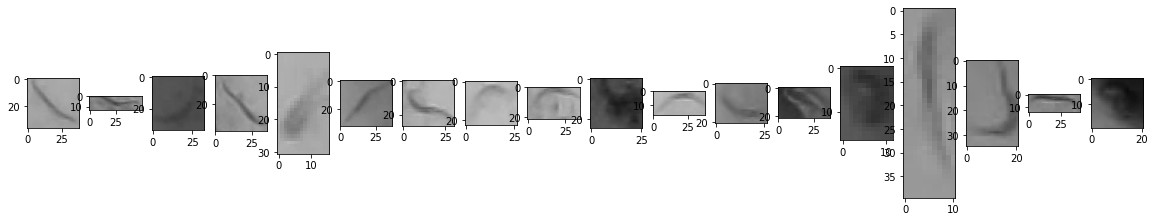

In [71]:
worm_ids = np.arange(0, len(viewer.tracked))
end_worms = viewer.fetch_worms(worm_ids, 2200)
new_worms = viewer.fetch_worms(worm_ids, 1600)


display_worms(end_worms)
# plt.imshow(end_worms[0])

## Now pass the worm images through the model.


In [72]:
worm_ids = np.arange(0, len(viewer.tracked))
end_worms = viewer.fetch_worms(worm_ids, 2000)
new_worms = viewer.fetch_worms(worm_ids, 1950)

def get_img_features(img):
    img = pre_process_img(img, mask_model=MASK_MODEL)
    x, feat = model.forward(img, features=True)
    feat = feat.detach().numpy()[0]
    return x, feat

_, worm0 = get_img_features(end_worms[4])

distances = []
classes = []

new_copy = new_worms.copy()

for w in new_copy: 
    x, feat = get_img_features(w)
    dist = np.linalg.norm(worm0 - feat)
    distances.append(dist)
    classes.append(x)
    
min_dst = np.argmin(distances)
print(min_dst)
print(distances[min_dst])
print(_, classes[min_dst])
# print(np.argmin(distances))
    
#     output = 1 if output > 0.5 else 0
# print(distances)
print(classes[5])
print(distances)

17
7.268174
tensor([[1.]], grad_fn=<SigmoidBackward>) tensor([[1.]], grad_fn=<SigmoidBackward>)
tensor([[1.]], grad_fn=<SigmoidBackward>)
[95.4198, 23.029547, 51.912125, 52.890995, 14.641429, 59.657536, 17.098833, 17.0014, 15.052069, 38.584614, 11.178467, 100.97532, 55.019283, 9.273891, 7.3434134, 8.237278, 19.15546, 7.268174]


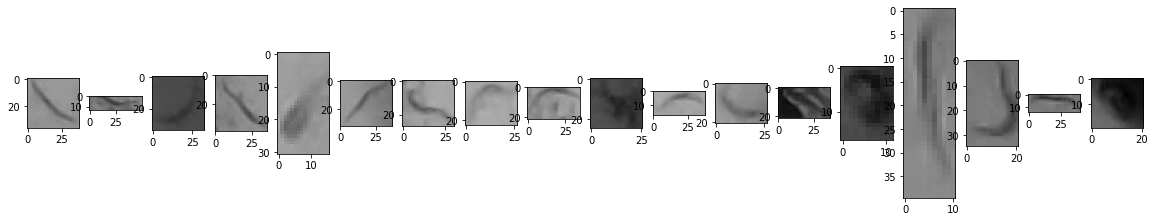

In [73]:
# new_worms = viewer.fetch_worms(worm_ids, 2000)
display_worms(end_worms)

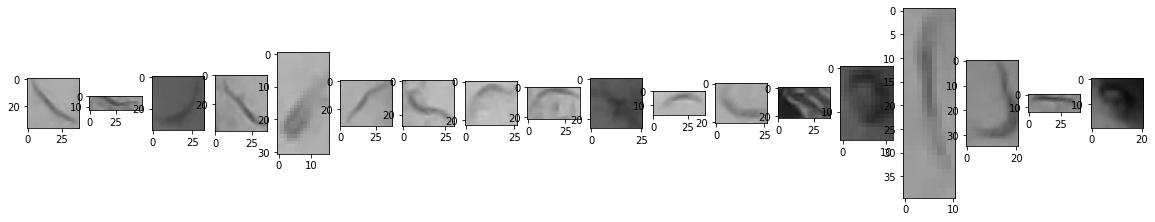

In [74]:
display_worms(new_worms)

0 0 4.3822765
1 1 4.26291
2 2 13.648307
3 3 9.4965
4 16 8.086662
5 5 3.231044
6 15 5.0634294
7 10 6.2644076
8 14 7.977967
9 9 2.3571532
10 16 4.6546288
11 11 7.6042123
12 12 2.8707385
13 17 7.0482535
14 14 3.9366045
15 17 5.8421307
16 10 4.787649
17 17 3.8571517


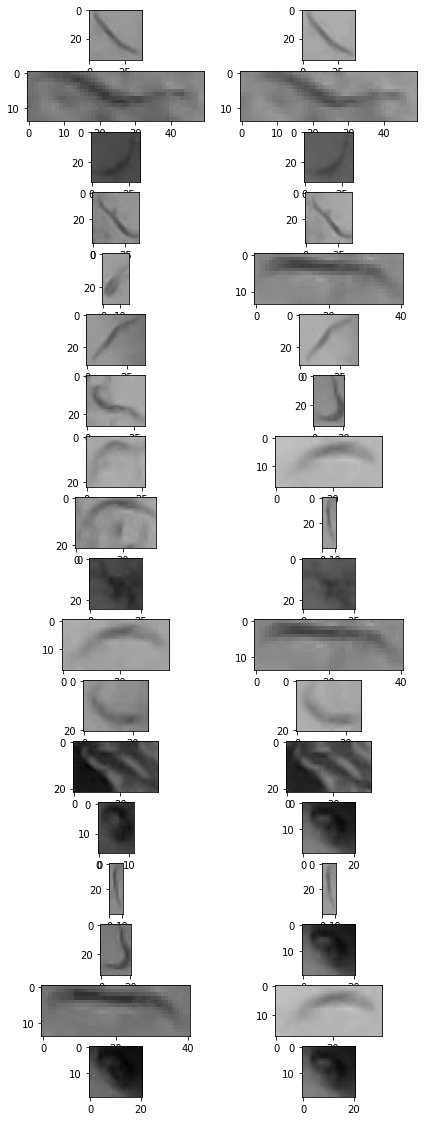

In [75]:
def bulk_features(img_list):
    features = []
    for worm in img_list:
        x, feature = get_img_features(worm)
        features.append(feature)
    return features


def find_worm_match(worm, worms):
    distances = []
    for w in worms:
        dist = np.linalg.norm(worm - w)
        distances.append(dist)
        
    match = np.argmin(distances)
    return match, distances[match]
        
worm_features_end = bulk_features(end_worms)
worm_features_new = bulk_features(new_worms)

fig = plt.figure(figsize=(7, 20))
z = 1
for i, worm in enumerate(worm_features_new):
    match, dist = find_worm_match(worm, worm_features_end)
    fig.add_subplot(18, 2, z)
    plt.imshow(end_worms[i])
    z +=1
    fig.add_subplot(18, 2, z)
    plt.imshow(new_worms[match])
    z +=1
    
    print(i, match, dist)
    

In [80]:
woi = 2
viewer = WormViewer(csv_path, vid_path)
first = True

worm_imgs = []
matches = []
for frame_id in tqdm(range(2400, 300, -10)):
    _, frame = viewer.get_frame(frame_id)
    viewer.update_tracked(frame_id, thresh=0.5)
  
    if frame_id % 20 == 0:
        worms = viewer.fetch_worms(worm_ids, frame_id)
        w = worms[woi]
        worm_imgs.append(w)
        
        features = bulk_features(worms)
        if first:
            reference = features[woi]
            first = False
        
        match = find_worm_match(reference, features)[0]
        matches.append(match)
        
print(matches)
#     for bb in viewer.tracked:
#         x, y, w, h = bb
#         cv2.rectangle(frame, (int(x),int(y)), (int(x+w), int(y+h)), (0,255,255), 2)

Determining Experiment End


100%|██████████| 25/25 [00:00<00:00, 38.72it/s]


Experiment Done @ Frame 1900
Processing in reverse from 2000


100%|██████████| 210/210 [00:15<00:00, 13.90it/s]

[2, 2, 13, 13, 13, 13, 17, 13, 14, 17, 17, 8, 17, 14, 9, 9, 13, 13, 2, 13, 14, 17, 14, 14, 14, 15, 1, 15, 17, 15, 6, 13, 17, 6, 15, 13, 14, 13, 6, 14, 17, 13, 8, 17, 6, 13, 8, 13, 17, 13, 13, 4, 9, 17, 7, 17, 13, 13, 13, 13, 17, 17, 13, 13, 4, 17, 4, 17, 13, 13, 17, 13, 13, 13, 13, 17, 13, 17, 13, 13, 13, 13, 13, 13, 13, 13, 13, 15, 13, 6, 13, 13, 13, 13, 17, 13, 13, 17, 13, 13, 13, 13, 6, 13, 13]


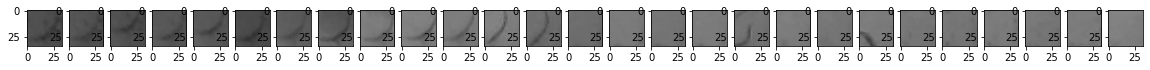

In [81]:
display_worms([worm_imgs[i] for i in range(0, len(worm_imgs), 4)])

In [82]:

distances = []
classes = []

for i, w in enumerate(worm_imgs):
    ref = max(0, i-10)
    _, worm0 = get_img_features(worm_imgs[5])
    
    x, features = get_img_features(w)
    dist = np.linalg.norm(worm0 - features)
    distances.append(dist)
    if x[0][0] < 0.5:
        classes.append(0)
    else:
        classes.append(1)
#     classes.append(x.to(int)[0][0])
    

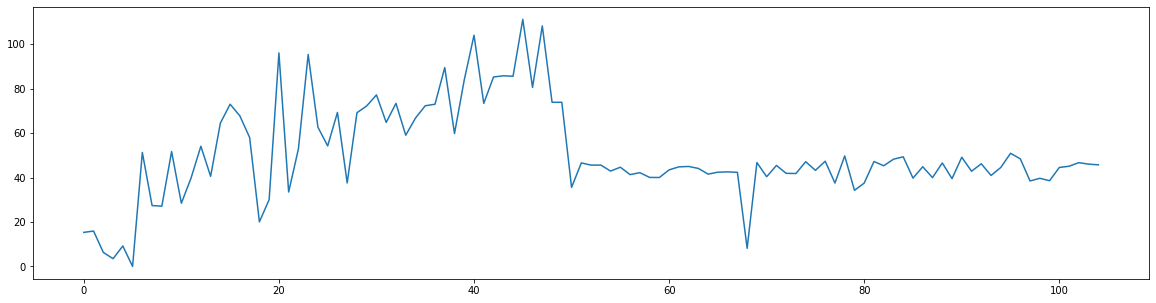

In [83]:
plt.plot(distances)

Text(0.5, 1.0, 'Bounding Box State Over The Experiemnt')

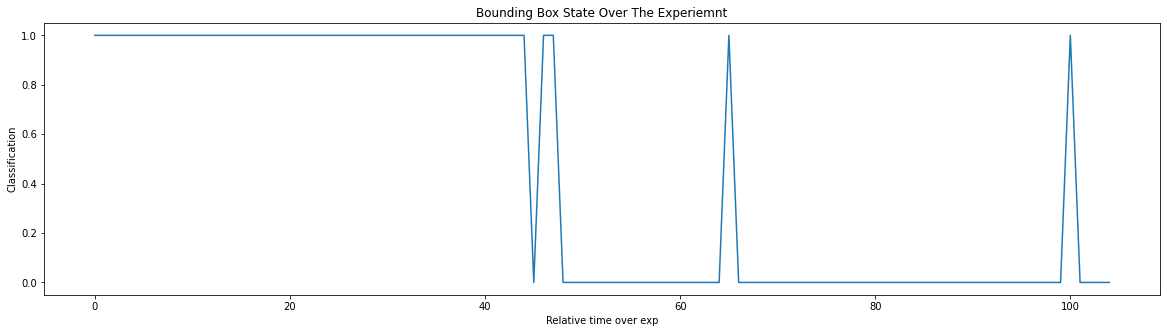

In [60]:
plt.plot(classes)
plt.xlabel("Relative time over exp")
plt.ylabel("Classification")
plt.title("Bounding Box State Over The Experiemnt")

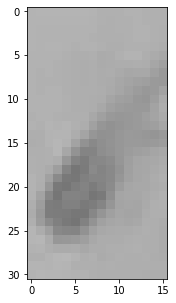

In [65]:
plt.imshow(new_worms[4])
test = pre_process_img(new_worms[4], mask_model=MASK_MODEL)

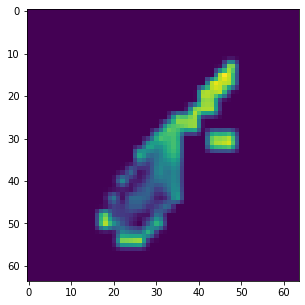

In [66]:
plt.imshow(test.squeeze(1).view(64,64,1))
